### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The shuffling of the dataframe was making a difference to whether the model would get started learning or not - with a shuffled dataset, I needed a lower learning rate. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [321]:
description = "continue training the focal only model"

In [441]:
# !pip install wandb
# ! pip install wandb --upgrade
! pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 35.4 MB/s eta 0:00:0000:0100:01


In [323]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [324]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [325]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [326]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [327]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch
from utils import plot_metrics_across_thresholds



In [328]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"


In [94]:
# df_train.sample()

# Set some hyperparameters

In [345]:
n_samples_per_class = 960
one_output_neuron = True
random_seed = 43
learning_rate = 0.002
epochs=15

In [346]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [347]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

train_df.value_counts()

target_absence  target_presence
1.0             0.0                45081
0.0             1.0                 4211
Name: count, dtype: int64

# Load focal recordings and split into train and valid sets
This is done by location and in accordance with the original train valid split locations. 

In [348]:
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" /"focal_osfls_thresh_0.99_ngen_1038.pkl")

# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)

# Split the focal clips into train and valid sets by filtering by the file paths at index of each dataset. 
focal_recs.index = new_index

train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

train_focal = focal_recs[train_focal_recs_idx]
valid_focal = focal_recs[valid_focal_recs_idx]

Only 6% of the focal samples were found as the first vocalization by the human labeller. 

In [349]:
intersect = train_focal.index.isin(train_df.index)
sum(intersect) / len(train_focal)

0.059375

In [350]:
len(train_focal)

960

There are 4000 present samples and 45081 absent samples avaliable for training. 

We can test the effect of mixing in extra samples by either:
- completely replacing the training present samples with focal ones
- mixing them in in ratios

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [351]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [352]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [353]:
print(n_samples_per_class)

960


In [354]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# # drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])
# second_balanced_train_df = second_balanced_train_df.drop(columns=["target_absence"])
balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])


balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    960
 1.0    960
 Name: count, dtype: int64,
 1920)

# Combine the absent samples from train_df with the focal samples


In [383]:
# Combine the absent samples from train_df with the focal samples
absent = train_df.loc[train_df.target_absence == 1]
absent.drop(columns=["target_absence"], inplace=True)
focal_train["target_presence"] = 1.0
focal_train = focal_train[["target_presence"]]
focal_train_df = pd.concat([absent, focal_train])
focal_train_df

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_57376/2691018800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absent.drop(columns=["target_absence"], inplace=True)


target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4396.mp3  0.0        3.0                   0.0
                                                   1.5        4.5                   0.0
                                                   3.0        6.0                   0.0
                                                   4.5        7.5                   0.0
                                                   6.0        9.0                   0.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-566231... 168.0      171.0                 1.0
../../data/raw/recordings/OSFL/recording-163473... 486.0      489.0                 1.0
                                                   493.5      496.5                 1.0
../../data/raw/recordings/OSFL/recording-292502... 136.5      139.5                 1.0
../../data/raw/recordings/OSFL/recording-294860... 55.5       58.5                  1.0

[46119 rows x 1 columns]

In [384]:
shuffled_focal_train_df = focal_train_df.sample(frac=1, random_state=random_seed)

In [393]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

In [396]:
balanced_train_df.columns, balanced_valid_df.columns, shuffled_focal_train_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

In [190]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

Or load a pretrained model from disk for further training

In [397]:
opso.cnn.load_model(model_save_path / 'first_focal_unbalanced2024-03-12.model') 

CNN(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [398]:
model.optimizer_params['lr'] = learning_rate


In [399]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [401]:
class_list

['target_presence']

In [402]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


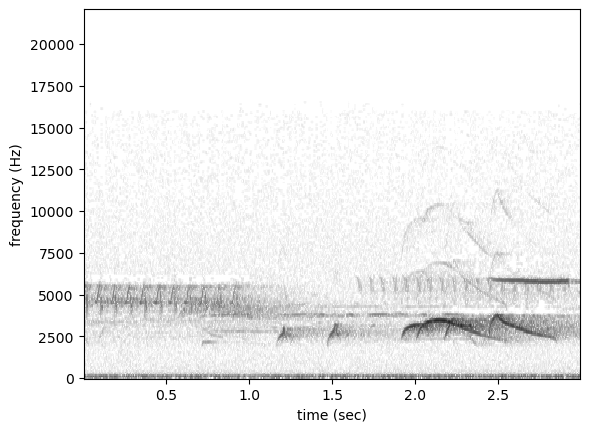

In [403]:
show_sample_from_df(present=True, df = shuffled_focal_train_df)


In [404]:
print(f'model.device is: {model.device}')

model.device is: mps


In [405]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [406]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [407]:
shuffled_balanced_valid_df.value_counts()

target_presence
0.0                500
1.0                500
Name: count, dtype: int64

In [408]:
shuffled_focal_train_df

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-291647.mp3,79.5,82.5,0.0
../../data/raw/recordings/OSFL/recording-320811.mp3,90.0,93.0,0.0
../../data/raw/recordings/OSFL/recording-292867.mp3,45.0,48.0,0.0
../../data/raw/recordings/OSFL/recording-291911.mp3,148.5,151.5,0.0
../../data/raw/recordings/OSFL/recording-98006.mp3,132.0,135.0,0.0
...,...,...,...
../../data/raw/recordings/OSFL/recording-315870.mp3,40.5,43.5,0.0
../../data/raw/recordings/OSFL/recording-293332.mp3,7.5,10.5,0.0
../../data/raw/recordings/OSFL/recording-566141.flac,18.0,21.0,0.0


In [409]:
# Loop 1 on the first balanced training set
model.train(
    shuffled_focal_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 17


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 17 [batch 0/721, 0.00%] 
	DistLoss: 0.001
Metrics:


wandb: Network error (ConnectionError), entering retry loop.


Epoch: 17 [batch 100/721, 13.87%] 
	DistLoss: 0.010
Metrics:
Epoch: 17 [batch 200/721, 27.74%] 
	DistLoss: 0.009
Metrics:
Epoch: 17 [batch 300/721, 41.61%] 
	DistLoss: 0.009
Metrics:
Epoch: 17 [batch 400/721, 55.48%] 
	DistLoss: 0.010
Metrics:
Epoch: 17 [batch 500/721, 69.35%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 17 [batch 600/721, 83.22%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 17 [batch 700/721, 97.09%] 
	DistLoss: 0.010
Metrics:
Metrics:
	MAP: 0.970

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.818

Training Epoch 18


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 18 [batch 0/721, 0.00%] 
	DistLoss: 0.001
Metrics:
Epoch: 18 [batch 100/721, 13.87%] 
	DistLoss: 0.013
Metrics:
Epoch: 18 [batch 200/721, 27.74%] 
	DistLoss: 0.012
Metrics:
Epoch: 18 [batch 300/721, 41.61%] 
	DistLoss: 0.011
Metrics:
Epoch: 18 [batch 400/721, 55.48%] 
	DistLoss: 0.011
Metrics:
Epoch: 18 [batch 500/721, 69.35%] 
	DistLoss: 0.011
Metrics:
Epoch: 18 [batch 600/721, 83.22%] 
	DistLoss: 0.011


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 18 [batch 700/721, 97.09%] 
	DistLoss: 0.011
Metrics:
Metrics:
	MAP: 0.967

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.834

Training Epoch 19


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 19 [batch 0/721, 0.00%] 
	DistLoss: 0.013
Metrics:
Epoch: 19 [batch 100/721, 13.87%] 
	DistLoss: 0.009
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch: 19 [batch 200/721, 27.74%] 
	DistLoss: 0.008
Metrics:
Epoch: 19 [batch 300/721, 41.61%] 
	DistLoss: 0.008
Metrics:
Epoch: 19 [batch 400/721, 55.48%] 
	DistLoss: 0.008
Metrics:
Epoch: 19 [batch 500/721, 69.35%] 
	DistLoss: 0.009
Metrics:
Epoch: 19 [batch 600/721, 83.22%] 
	DistLoss: 0.009
Metrics:
Epoch: 19 [batch 700/721, 97.09%] 
	DistLoss: 0.009
Metrics:
Metrics:
	MAP: 0.978

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.812

Training Epoch 20


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 20 [batch 0/721, 0.00%] 
	DistLoss: 0.004


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 20 [batch 100/721, 13.87%] 
	DistLoss: 0.007
Metrics:
Epoch: 20 [batch 200/721, 27.74%] 
	DistLoss: 0.007
Metrics:
Epoch: 20 [batch 300/721, 41.61%] 
	DistLoss: 0.008


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 20 [batch 400/721, 55.48%] 
	DistLoss: 0.009
Metrics:
Epoch: 20 [batch 500/721, 69.35%] 
	DistLoss: 0.009
Metrics:
Epoch: 20 [batch 600/721, 83.22%] 
	DistLoss: 0.009
Metrics:
Epoch: 20 [batch 700/721, 97.09%] 
	DistLoss: 0.009
Metrics:
Metrics:
	MAP: 0.979

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

dyld[88151]: Assertion failed: (this->magic == kMagic), function matchesPath, file Loader.cpp, line 154.



RuntimeError: DataLoader worker (pid(s) 88151) exited unexpectedly

In [308]:
# Loop 2 on the first balanced training set
model.train(
    shuffled_focal_train_df,
    shuffled_balanced_valid_df,
    epochs = 2,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 15


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 15 [batch 0/721, 0.00%] 
	DistLoss: 0.001


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 15 [batch 100/721, 13.87%] 
	DistLoss: 0.007
Metrics:
Epoch: 15 [batch 200/721, 27.74%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 300/721, 41.61%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 400/721, 55.48%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 500/721, 69.35%] 
	DistLoss: 0.009


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 15 [batch 600/721, 83.22%] 
	DistLoss: 0.010
Metrics:
Epoch: 15 [batch 700/721, 97.09%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Metrics:
	MAP: 0.975

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.823

Training Epoch 16


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 16 [batch 0/721, 0.00%] 
	DistLoss: 0.002
Metrics:
Epoch: 16 [batch 100/721, 13.87%] 
	DistLoss: 0.007
Metrics:
Epoch: 16 [batch 200/721, 27.74%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 300/721, 41.61%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 400/721, 55.48%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 16 [batch 500/721, 69.35%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:


wandb: Network error (ConnectionError), entering retry loop.


Epoch: 16 [batch 600/721, 83.22%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 700/721, 97.09%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Metrics:
	MAP: 0.973

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.810

Best Model Appears at Epoch 15 with Validation score 0.823.


# Adding a second training set reduced validation score. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [276]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_1038_focal_45081_absent{dt}")

# Show metrics

In [413]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.9388057846899065,
   'avg_precision': 0.7049026023273377,
   'precision': 0.9886049268871031,
   'recall': 0.9988243123336291,
   'f1': 0.9936883455079116,
   'support': 45080},
  'precision': 0.9480546449444242,
  'recall': 0.7496527721437154,
  'f1': 0.8194248179152461,
  'jaccard': 0.7318231707253396,
  'hamming_loss': 0.012402697369847568,
  'map': 0.7049026023273377,
  'au_roc': 0.9388057846899065},
 1: {'target_presence': {'au_roc': 0.9829521765604596,
   'avg_precision': 0.8841692490238289,
   'precision': 0.9941907980474013,
   'recall': 0.9984472049689441,
   'f1': 0.996314455524443,
   'support': 45080},
  'precision': 0.9557242406312656,
  'recall': 0.8726595986346164,
  'f1': 0.909828315295378,
  'jaccard': 0.8461927318964454,
  'hamming_loss': 0.0072204514408378325,
  'map': 0.8841692490238289,
  'au_roc': 0.9829521765604596},
 2: {'target_presence': {'au_roc': 0.9871366314446438,
   'avg_precision': 0.9077162378514531,
   'precision': 

In [410]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.7458199999999999,
   'avg_precision': 0.7910266993982749,
   'precision': 0.5388768898488121,
   'recall': 0.998,
   'f1': 0.699859747545582,
   'support': 500},
  'precision': 0.7626816881676493,
  'recall': 0.572,
  'f1': 0.47710757412122307,
  'jaccard': 0.34200207998242993,
  'hamming_loss': 0.428,
  'map': 0.7910266993982749,
  'au_roc': 0.7458199999999999},
 1: {'target_presence': {'au_roc': 0.7659400000000001,
   'avg_precision': 0.8170671024085576,
   'precision': 0.5405405405405406,
   'recall': 1.0,
   'f1': 0.7017543859649124,
   'support': 500},
  'precision': 0.7702702702702703,
  'recall': 0.575,
  'f1': 0.4813119755911518,
  'jaccard': 0.3452702702702703,
  'hamming_loss': 0.425,
  'map': 0.8170671024085576,
  'au_roc': 0.7659400000000001},
 2: {'target_presence': {'au_roc': 0.760096,
   'avg_precision': 0.8088609443191084,
   'precision': 0.5330490405117271,
   'recall': 1.0,
   'f1': 0.6954102920723227,
   'support': 500},
  'precis

In [297]:
# load the best model
# best_model = opso.cnn.load_model("best.model")

In [411]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

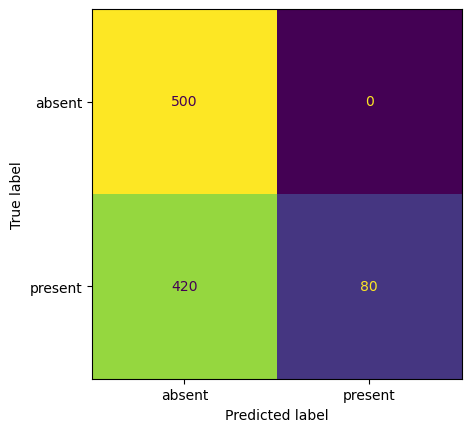

In [412]:
def model_to_cm(model, df):
    shuf_preds = model.predict(df)
    shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
    scores = shuf_preds.sigmoid_prediction.values
    targets = df.target_presence.values
    cm = opso.metrics.M.confusion_matrix(targets, scores.round())
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
    cm_display.plot(colorbar=False)
    return scores, targets

scores, targets = model_to_cm(model, shuffled_balanced_valid_df)


  0%|          | 0/1000 [00:00<?, ?it/s]

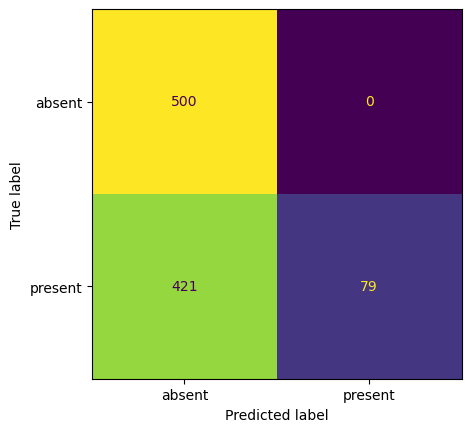

In [312]:
epoch_n_model = opso.cnn.load_model("epoch-16.model")
_, __ = model_to_cm(model, shuffled_balanced_valid_df)

Using only focal samples for the present class has the effect of increasing precision at the expense of recall. This is for a threshold of 0.5, so other thresholds should be tried. 

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 

In [414]:
cleaned_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
# Remove the 'discard' samples from the validation set
cleaned_valid_df.drop(cleaned_valid_df.loc[cleaned_valid_df.confidence_cat == 1].index, inplace=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10694 [00:00<?, ?it/s]

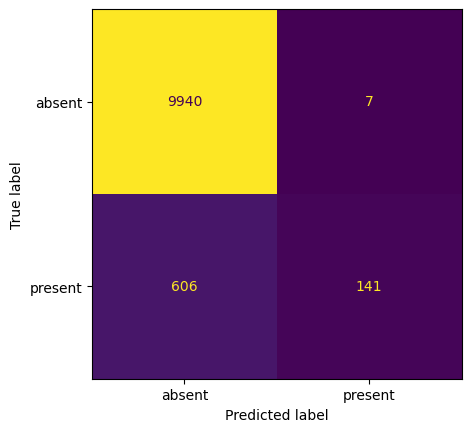

In [415]:
scores, targets = model_to_cm(model, cleaned_valid_df)

In [416]:
wandb.log({"validation.confusion_matrix" : wandb.plot.confusion_matrix(preds=scores.round(),
                        y_true=targets,
                        class_names=["absent", "present"])})

In [417]:
wandb.sklearn.plot_confusion_matrix(targets, scores.round(), ["absent", "present"])

# Look at the metrics across thresholds

In [456]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



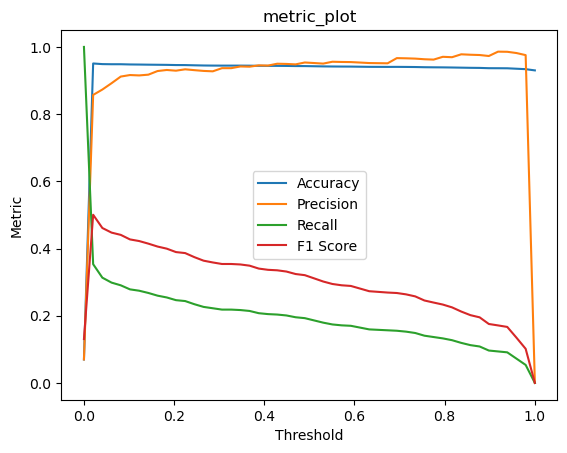

<Figure size 640x480 with 0 Axes>

In [463]:
plot = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}), title="metric_plot")
wandb.log({"vary_threshold_plot":wandb.Image(plot.gcf())})

<Figure size 640x480 with 0 Axes>

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


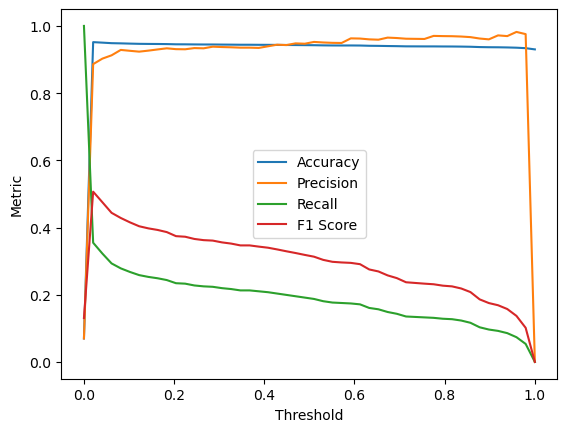

<Figure size 640x480 with 0 Axes>

In [ ]:
vary_threshold_plot = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
vary_threshold_plot.savefig('vary_threshold_plot.png')
wandb.log({"vary_threshold_plot": wandb.Image('vary_threshold_plot.png')})

# Result: 

This training run increased precision at the expense of recall. There were numerous factors changed at once here though - so the change in precision can't be directly attributed to the focal samples. 

- the absent / present ratio was far more skewed than before: there are approximately 40 times more absent samples than present samples in this dataset - the 

# Save the best model

In [45]:
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [464]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



epoch,▁▅█
loss,▆█▂▁
epoch,2
loss,0.00853


In [451]:
model.save(f"first_focal_unbalanced{dt}.model")